# Исследование интернет-магазина компьютерных игр "Стримчик"

### Описание исследования

#### Цель исследования

Провести анализ данных при помощи которых предприятие разработает стратегию реализации продукта. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

#### Задачи исследования

Нам нужно выявить определяющие успешность игры закономерности.

#### Исходные данные

В нашем распоряжении данные интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. В датасете доступны исторические данные до 2016 года о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

### Изучение общей информации

#### Библиотека

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math

# import warnings
# warnings.filterwarnings('ignore') # игнорирую подсказки юпитера 

#### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# проверю размерность таблицы на входе, чтобы сравнить после предобработки
data.shape

(16715, 11)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.isna().sum()  #  выгрузим строки с пустыми значениями

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
data.duplicated().sum() # проверка строк на дубликаты

0

In [7]:
data.duplicated(subset=['Name', 'Platform', 'Year_of_Release']).sum() 
# проверю неявные дубликаты для связки Название игры - Платформа - Год

2

In [8]:
duplicateRows = data[data.duplicated(['Name', 'Platform', 'Year_of_Release'])]

duplicateRows  # выведу последние строки совпадений

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.0,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.0,83.0,5.5,E


In [9]:
duplicateRows_last = data[data.duplicated(['Name', 'Platform', 'Year_of_Release'], keep='last')]

duplicateRows_last # выведу первые строки совпадений

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN


In [10]:
data = data.drop(index=[604, 659]) # точечно удалю дубли с наименьшей информацией о продажах

In [11]:
data.duplicated(subset=['Name', 'Platform', 'Year_of_Release']).sum() 

0

##### Вывод

Мы познакомились с файлом: 16715 строк × 11 столбцов (5 из них типа object, 6 - float). На первый взгляд странно, что год выгружен в типе float. Так же есть вопросы по типу столбца с оценкой пользователей. Для количесвтенных переменных такой формат не самый оптимальный. Уделим внимание этим вопросам в следующей части предобработки данных. 

Явных дубликатов в файле нет. Были выявлны и устранены неявные дубликаты.

#### Предобработка данных

In [12]:
data.columns = data.columns.str.lower()  # приведем названия столбцов к нижнему регистру

Изучим данные каждого столбца

##### name (название игры)

Проверим строки с отсутствующими данными названия игры

In [13]:
data.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993.0,NaN,0.0,0.0,0.03,0.0,NaN,NaN,NaN


In [14]:
data = data.dropna(subset=['name'])  # избавимся от обезличенных строк> 

Посмотрим количество уникальных значений для выявления возможных дублей.

In [15]:
data['name'].value_counts()

Need for Speed: Most Wanted                              12
Madden NFL 07                                             9
FIFA 14                                                   9
LEGO Marvel Super Heroes                                  9
Ratatouille                                               9
                                                         ..
Double Dragon                                             1
Saltwater Sportfishing                                    1
Kyoukai Senjou no Horizon Portable                        1
Nicktoons Collection: Game Boy Advance Video Volume 1     1
Ikki Tousen: Xross Impact                                 1
Name: name, Length: 11559, dtype: int64

Некоторые игры встречаются в таблице до 12 раз. Проверим на примере Need for Speed: Most Wanted как выглядят строки.

In [16]:
data.query('name == "Need for Speed: Most Wanted"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Мы видим, что годы релиза преимущественно у игр разные, а там где год пересекается - мы видим разность платформ, что говорит об уникальности этих строк и их ценности.

##### platform (платформа)

Проверим уникальные значения для столбца.

In [17]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

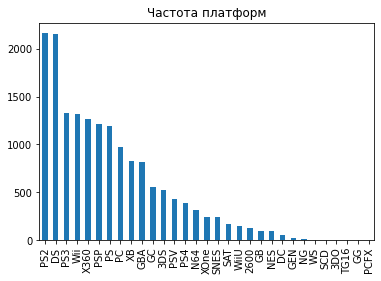

In [18]:
data['platform'].value_counts().plot.bar(title='Частота платформ'); 

# выведем график на экран для визуальной оценки распределения популярности платформ

Данные выглядят корректно. Тип соответствует представленному. Пропущенных значений не обнаружено.

##### year_of_release (год выпуска)

In [19]:
non_year = data.query('year_of_release.isna()') # проверим количество строк с отсутствующей датой
len(non_year)

269

In [20]:
non_year.describe()  # оценим данные источника

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,0.0,269.000000,269.000000,269.000000,269.000000,154.000000
mean,NaN,0.219888,0.090929,0.024907,0.032007,67.584416
std,NaN,0.424907,0.207933,0.090160,0.075546,14.828740
min,NaN,0.000000,0.000000,0.000000,0.000000,22.000000
25%,NaN,0.010000,0.000000,0.000000,0.000000,57.000000
50%,NaN,0.090000,0.020000,0.000000,0.010000,70.000000
75%,NaN,0.240000,0.100000,0.000000,0.030000,78.000000
max,NaN,4.260000,2.360000,0.770000,0.710000,94.000000


In [21]:
non_year['total_sale'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis='columns')
non_year['total_sale'].sum()

/tmp/ipykernel_181/1078526792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_year['total_sale'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis='columns')


98.91999999999999

In [22]:
data = data.dropna(subset=['year_of_release']) # избавимся от пропусков в столбце год релиза, чтобы корректно работать с датой 

Изменим тип данных для столбца с годом релиза с float на int

In [23]:
data['year_of_release'] = data['year_of_release'].astype('int')

In [24]:
print('Временной период данных, представленный в таблице:', 
      data['year_of_release'].min(), '-', data['year_of_release'].max())

Временной период данных, представленный в таблице: 1980 - 2016


Мы привели данные столбца с годом выпуска к типу данных int для удобной работы со значениями и избавились от 269 строк с пропущенными значений в этом стобце.

##### genre (жанр игры)

In [25]:
data.query('genre.isna()') # выведем строки с пустыми значениями столбца

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


После чистки предыдущих столбцов, пропущенных значений в стобце genre не осталось. Проверим корректность данных, выгрузив уникальные значения и визуализируем данные.

In [26]:
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

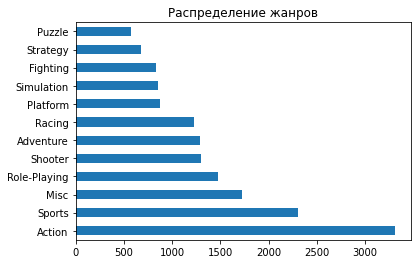

In [27]:
data['genre'].value_counts().plot.barh(title='Распределение жанров'); 

Данные выглядят корректно. Самый популярный жанр представленного датафрейма - Action, самый не популярный - Puzzle.

##### na_sales, eu_sales, jp_sales, other_sales / продажи в Северной Америке, продажи в Европе, продажи в Японии, продажи в других странах (миллионы проданных копий)

В представленных столбцах пропущенных значений нет. Выведу описание каждого для визуальной оценки размаха значений.

In [28]:
data['na_sales'].describe()

count    16443.000000
mean         0.263900
std          0.818276
min          0.000000
25%          0.000000
50%          0.080000
75%          0.240000
max         41.360000
Name: na_sales, dtype: float64

In [29]:
data['eu_sales'].describe()

count    16443.000000
mean         0.145926
std          0.506731
min          0.000000
25%          0.000000
50%          0.020000
75%          0.110000
max         28.960000
Name: eu_sales, dtype: float64

In [30]:
data['jp_sales'].describe()

count    16443.000000
mean         0.078492
std          0.311109
min          0.000000
25%          0.000000
50%          0.000000
75%          0.040000
max         10.220000
Name: jp_sales, dtype: float64

In [31]:
data['other_sales'].describe()

count    16443.000000
mean         0.047583
std          0.188006
min          0.000000
25%          0.000000
50%          0.010000
75%          0.030000
max         10.570000
Name: other_sales, dtype: float64

Аномально выбивающихся значений не обнаружено.

##### critic_score, user_score / оценка критиков (максимум 100), оценка пользователей (максимум 10)

###### critic_score

Выведем описание столбца оценки критиков, чтобы определить вписывается ли массив данных в установленные рамки формата оценки.

In [32]:
data['critic_score'].describe()

count    7982.000000
mean       68.992608
std        13.920049
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

Данные корректны в своих пределах. 
Так как почти половина значений столбца пропущено, избавиться от таких строк мы не можем. Заменить средним значением тоже будет не корректно, тк отсутствующая оценка критиков может дать нам дополнительную информацию в рамках дальнейшего исследования закономерностей.

In [33]:
data['critic_score'].describe()

count    7982.000000
mean       68.992608
std        13.920049
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

Выведем распределение оценки критиков на график:

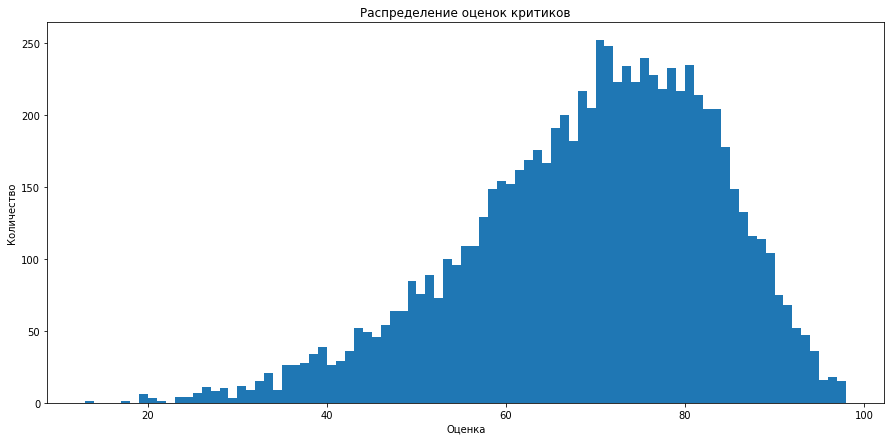

In [34]:
data['critic_score'].plot(
    kind='hist', bins=85, figsize=(15,7), 
    title='Распределение оценок критиков').set(xlabel='Оценка', ylabel='Количество');

Распределение в рамках Пуассона. Аномальных выбросов не замечено.

###### user_score

Изучая данные, мы отметили, что оценка пользователей выгружена в формате object, что некорректно для работы с таким видом данных.

Выведем уникальные значения оценки пользователей, чтобы определить вписывается ли массив данных в установленные рамки формата оценки и приведем столбцеу к типу float.

In [35]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Мы видим наличие строкового типа "tbd", который и приводит наш столбце к общему типу object

TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято.

В рамках нашего исследования метка TBD носит такую же ценность как и отсутствующее значение, поэтому изменим его на nan, чтобы привести столбец к типу float.

In [36]:
data['user_score'] = data['user_score'].replace('tbd', 'nan')

In [37]:
data['user_score'] = data['user_score'].astype('float')

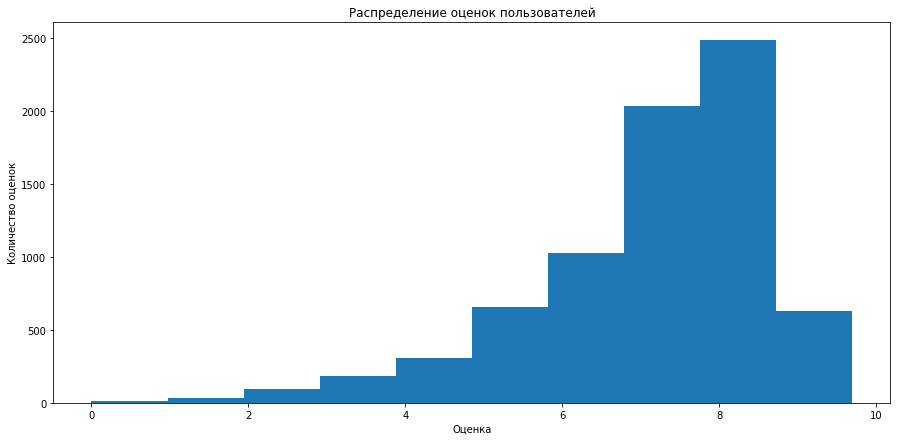

In [38]:
data['user_score'].plot(kind='hist',
    bins=10, figsize=(15,7), title='Распределение оценок пользователей').set(
        xlabel="Оценка", ylabel="Количество оценок");

Распределение в рамках Пуассона. Аномальных выбросов не замечено. Отчетливо виден пик оценок в срезе от 7 до 9.

##### rating рейтинг возрастной категории от организации ESRB

In [39]:
data['rating'].value_counts()

E       3920
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Имеющиеся данные соответствуют документации ESRB. 
Пропущенные данные могут говорить о том, что продукт не отправлен на оценку в ESRB для присвоения рейтинга или он ожидается. Заменим отсутствующие значения на TBD 

In [40]:
data['rating'] = data['rating'] .fillna('TBD')

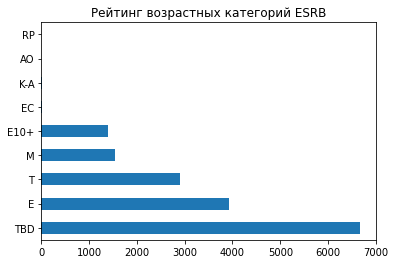

In [41]:
data['rating'].value_counts().plot.barh(title='Рейтинг возрастных категорий ESRB'); 

Больше всего данных предсатвлено по продуктам не отправленых на оценку в ESRB или она ожидается. Оценка «E» («Everyone») — «Для всех» - лидирует в списке из имеющегося рейтинга.

##### Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец total_sales

In [42]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,TBD,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,TBD,31.38


In [43]:
# проверю остаток строк
data.shape  

(16443, 12)

Чистка прошла корректно. Минус 272 строки и плюс один новый столбец в датафрейеме total_sales.

##### Вывод

Мы обработали имеющиеся данные и удалили строки, которые нет возможности корректно идентифицировать. Множество строк с пропущенными значениями столбцов critic_score и user_score могли образоваться в связи с отсутствующими методиками сбора данных, к примеру на ранних этапах до 2000 года. Пропущенные данные ESRB могут говорить о том, что продукт не был отправлен на оценку в ESRB для присвоения рейтинга. Рейтинги ESRB дейтвительны в США и Канаде. Но есть и другие рейтинговые системы оценки игр: PEGI в Европе, CERO в Японии. Значит данный рейтинг только для США и Канады, а в нашей таблице данных много других регионов, поэтому пропуски имеют логическую связь с тем кто эти рейтинги выставляет.
Cтроки с пропущенными значениями наименования игры и жанра могут быть связаны с технической ошибкой, например невозможность обработки значений на кириллице. Возможна иная техническая ошибка в процессе сбора данных или их выгрузки + человеческий фактор.

В процесее проверки данных с датой релиза мы привели столбец к типу int для удобной работы с датафреймом и избавились от 269 строк с пропущенными значениями в этом стобце.

Пропущенные значения в столбце с оценкой критиков мы оставили для работы в базовом виде, так как это почти половина значений столбца, избавиться от таких строк мы не можем. Заменить средним значением тоже будет некорректно, тк будет значительный "перекос" данных + отсутствующая оценка критиков может дать нам дополнительную информацию в рамках дальнейшего исследования закономерностей.

Мы изменили тип данных в столбце с оценкой пользователей на float, чтобы корректно работать с данными стобца. Для этого мы отказались от статуса TBD в имеющихся значениях. Но это не повлияет на корректность исследования, тк у колличественных данных, по которым информация не определена (tbd) ценность такая же как у строк с отсутствующими данными.

Для столба rating мы наоборт позаимствовали методику присвоения tbd (продукт не отправлен на оценку в ESRB для присвоения рейтинга или он ожидается) для пропущенных значений, тк актуальный тип данных там object, а статут tbd позволит нам удобно ориентироваться в графиках.

Также мы посчитали суммарные продажи во всех регионах и записали их в отдельный столбец total_sales.

### Исследовательский анализ

#### Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [44]:
# data['year_of_release'].hist(bins=37, figsize=[20, 10]);  # визуализируем данные 

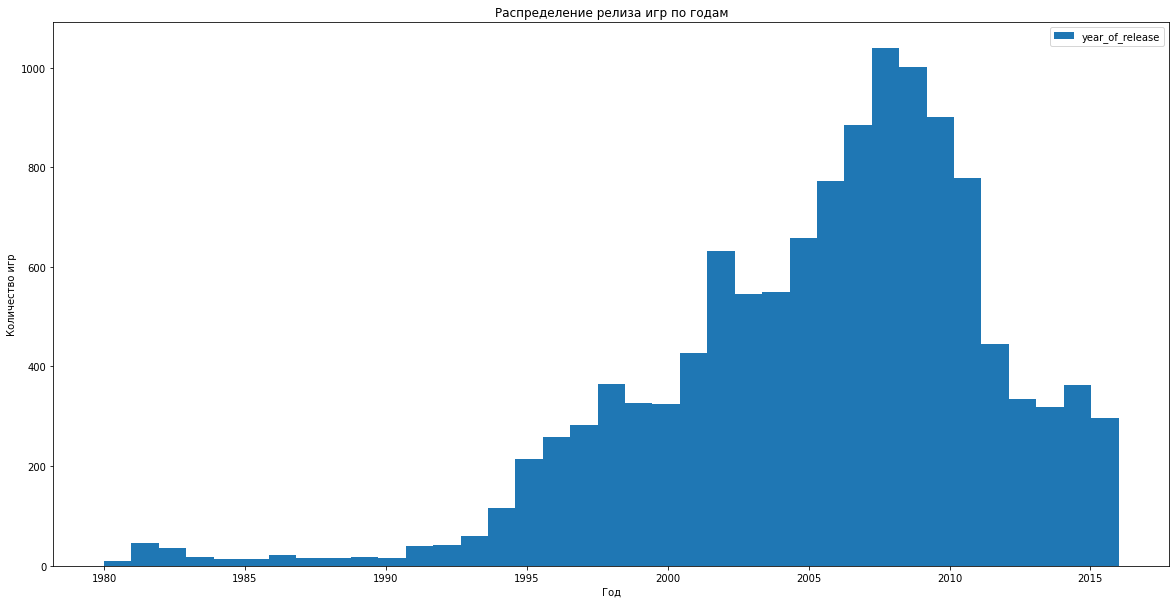

In [45]:
release_game = data[['name', 'year_of_release']].drop_duplicates()
release_game.plot(kind='hist',
    bins=37, figsize=[20, 10], 
    title='Распределение релиза игр по годам').set(xlabel='Год', ylabel='Количество игр');

Мы видим заметный рост выпущенных игр после 1995 года и резкий рост после 2000. Предсатвим эти значения на графике ящик с усами.

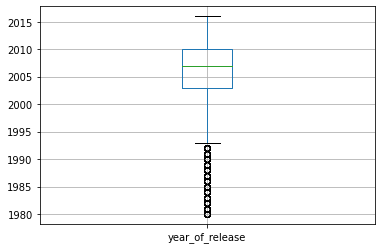

In [46]:
data.boxplot(column='year_of_release');

Заметны выбросы ниже левой границы. Ознакомимся подробнее с выбросами до 1993.

In [47]:
data.query('year_of_release < 1993').head(20)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,TBD,40.24
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,TBD,30.26
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,TBD,28.31
18,Super Mario World,SNES,1990,Platform,12.78,3.75,3.54,0.55,NaN,NaN,TBD,20.62
21,Super Mario Land,GB,1989,Platform,10.83,2.71,4.18,0.42,NaN,NaN,TBD,18.14
22,Super Mario Bros. 3,NES,1988,Platform,9.54,3.44,3.84,0.46,NaN,NaN,TBD,17.28
50,Super Mario Land 2: 6 Golden Coins,GB,1992,Adventure,6.16,2.04,2.69,0.29,NaN,NaN,TBD,11.18
76,Super Mario Kart,SNES,1992,Racing,3.54,1.24,3.81,0.18,NaN,NaN,TBD,8.77
89,Pac-Man,2600,1982,Puzzle,7.28,0.45,0.00,0.08,NaN,NaN,TBD,7.81
98,Super Mario Bros. 2,NES,1988,Platform,5.39,1.18,0.70,0.19,NaN,NaN,TBD,7.46


Информация об оценке критиков, оценке пользователей, а также рейтинг ESRB преимущественно отсутсвует в данных до 1993 года. Этот период видится наименее значимым в представленном датафрейме.

#### Посмотрим как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Посмотрим за какой характерный срок появляются новые и исчезают старые платформы.

Выведем таблицу с рейтингом платформ по выручке.

In [48]:
top_platforms = data.pivot_table(
    index='platform', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False)
top_platforms.head(10)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,928.78
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


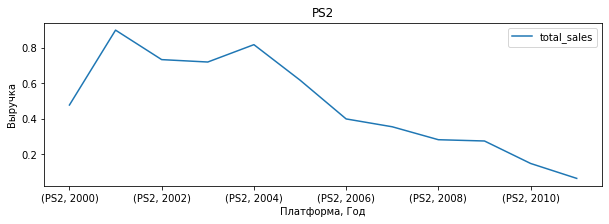

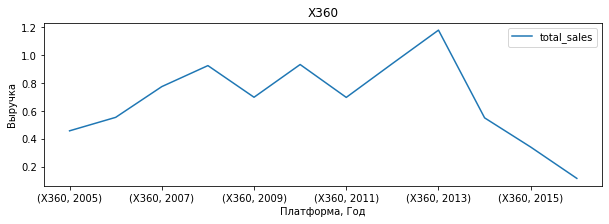

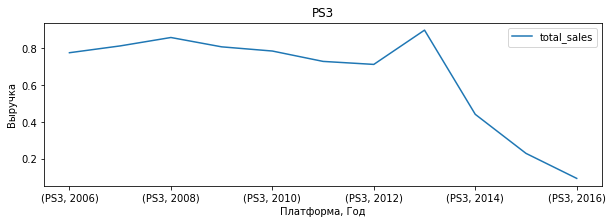

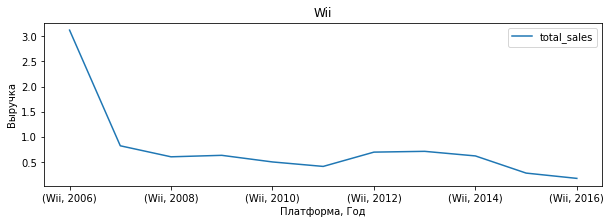

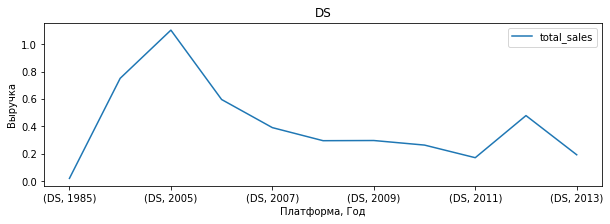

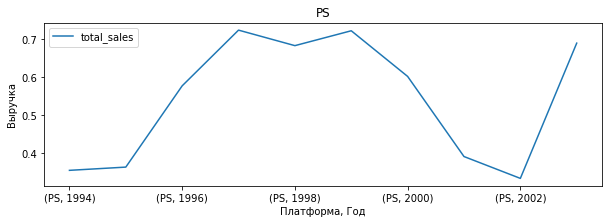

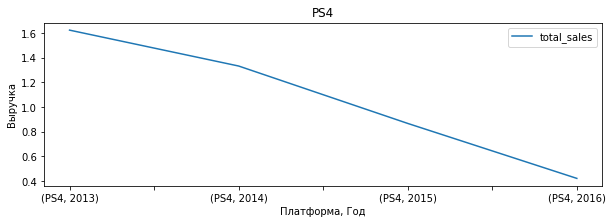

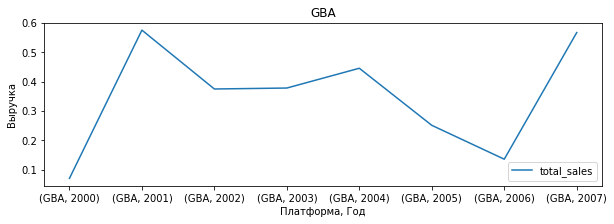

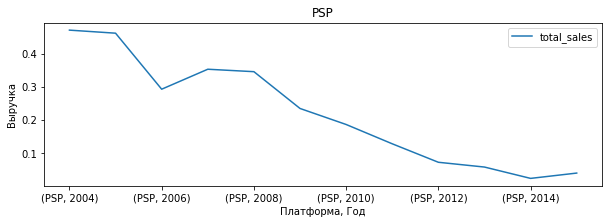

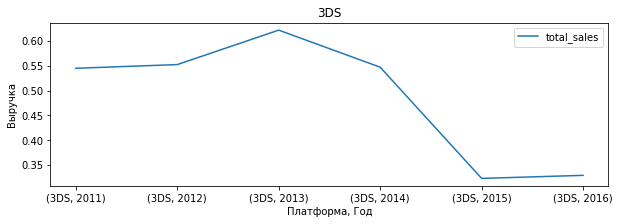

In [49]:
# формируем сводную таблицу из топ платформ
tmp = data.pivot_table(
    index='platform', values='total_sales', aggfunc= 'sum').sort_values(
    'total_sales', ascending=False) 

# создаем список из наименований топ платформ
tmp_list = tmp.index[:10].tolist()

# выводим таблицу из которой будем брать инфу по годам
top_platforms_data = data.query(
    "platform.isin(@tmp_list)")
top_platforms_data = top_platforms_data.pivot_table(
    index=['platform', 'year_of_release'], values = 'total_sales')

# оформляем цикл с выводом графика по каждой топ платформе
for i in tmp_list:
    top_platforms_data.query('platform == @i').plot(title=i, figsize=(10, 3)).set(xlabel='Платформа, Год', ylabel='Выручка');

In [50]:
tmp_list

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']

In [51]:
data.query('platform == "DS" and year_of_release < 2004')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,TBD,0.02


In [52]:
data = data.drop(index=15957)

Рассмотрим детальнее жизненный цикл всех платформ из датафрейма.

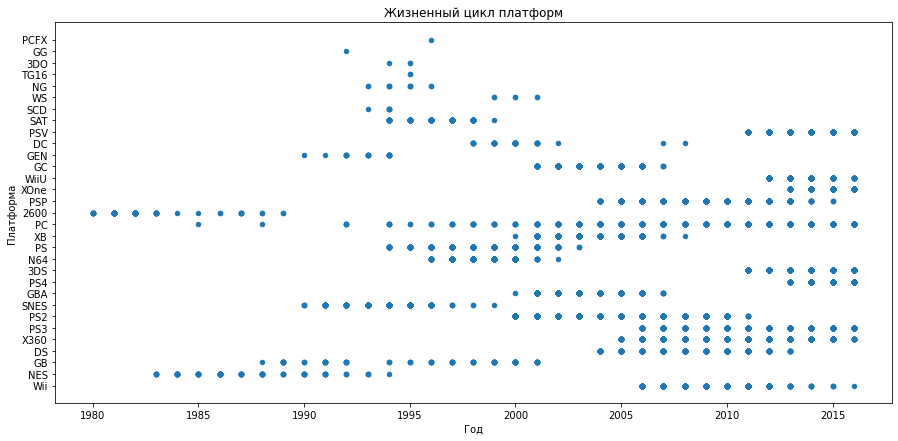

In [53]:
data.plot(
    x='year_of_release', 
    y='platform', 
    kind='scatter', 
    figsize=(15,7), title='Жизненный цикл платформ').set(xlabel='Год', ylabel='Платформа');

На графике видно, как стремительно меняются платформы со временем. Посчитаем средний жизненный цикл платформ.

In [54]:
# cформирую сводную таблицу с датой первого релиза игры на платформе и датой последнего
life = data.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']) 

# вычту одно из другого и добавлю столбец по каждой платформе
life['time_life'] = life['max']['year_of_release'] - life['min']['year_of_release']  

# выведу среднее по столбцу с временем жизни платформы
print('Средний жизненный цикл игровой платформы', round(life['time_life'].mean()), 'лет') 

Средний жизненный цикл игровой платформы 7 лет


Теперь посмотрим какой средний срок появления новой платформы.

In [55]:
# выведу даты первых релизов на платформе и отсортирую по возрастанию
start_date = life['min']['year_of_release'].sort_values()
start_date

platform
2600    1980
NES     1983
PC      1985
GB      1988
SNES    1990
GEN     1990
GG      1992
SCD     1993
NG      1993
SAT     1994
PS      1994
3DO     1994
TG16    1995
PCFX    1996
N64     1996
DC      1998
WS      1999
GBA     2000
XB      2000
PS2     2000
GC      2001
DS      2004
PSP     2004
X360    2005
PS3     2006
Wii     2006
PSV     2011
3DS     2011
WiiU    2012
PS4     2013
XOne    2013
Name: year_of_release, dtype: int64

In [56]:
print('Всего платформ в датафрейме', data['platform'].value_counts().count())

Всего платформ в датафрейме 31


In [57]:
# выведу даты последних релизов на платформе и отсортирую по возрастанию

end_date = life['max']['year_of_release'].sort_values()  
end_date.head(11)

platform
2600    1989
GG      1992
SCD     1994
GEN     1994
NES     1994
3DO     1995
TG16    1995
NG      1996
PCFX    1996
SNES    1999
SAT     1999
Name: year_of_release, dtype: int64

In [58]:
platform_list = []
x = 1980

# добавлю фильтрацию по уникальным годам, чтобы исключить искажение данных за счет годов с 'богатыми' релизами
for i in set(start_date):
    y = i - x
    platform_list.append(y)
    x = i

print('В среднем, каждые', round(sum(platform_list) / len(platform_list), 1), "года появляется новая платформа")

В среднем, каждые 1.6 года появляется новая платформа


##### Вывод 

У большинства платформ с топовой выручкой отслеживается устойчивое падение прибыли c каждым годом. Это может быть связано с тем, что часть игрового продукта с каждым годом переходит в онлайн. 

Многие платформы устарели, например, платформа 2600 была только до 1990 года. Еще 10 платформ (GG, SCD, GEN, NES, 3DO, TG16, NG, PCFX, SNES, SAT) остались в прошлом веке.

Средний жизненный цикл игровых платформ 7 лет, а в среднем каждые 1.6 года появляется новая платформа. 

Такая динамика изменений в индустрии сужает актуальный период для построения прогноза на 2017 год. Платформу X360 в 2016 году уже не выпускали, у PS3 поддержка закончилась так же в 2016 году. Nintendo WII и DS тоже не поддерживаются с 2013 года. Считаю корректным взять срез данных за последние 3 года так как это поможет наиболее точного построить прогноз на основе данных актуальных платформ.

#### Возьмем данные за соответствующий актуальный период ( как решено выше - последние 3 года)

In [59]:
actual_data = data.query('year_of_release > 2013')
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,TBD,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,TBD,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,TBD,7.98


In [60]:
print('Поддерживаемых платформ после 2013 года осталось', actual_data['platform'].value_counts().count(), 
      actual_data['platform'].unique())

Поддерживаемых платформ после 2013 года осталось 10 ['PS4' '3DS' 'XOne' 'WiiU' 'PS3' 'X360' 'PC' 'Wii' 'PSV' 'PSP']


#### Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.

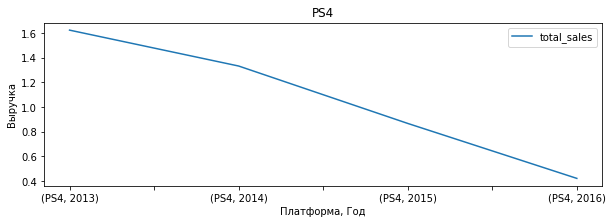

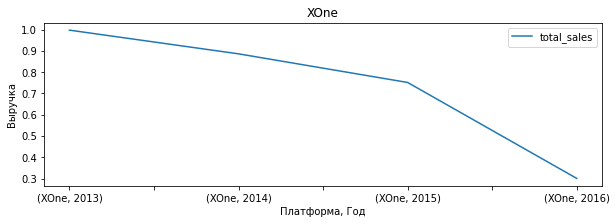

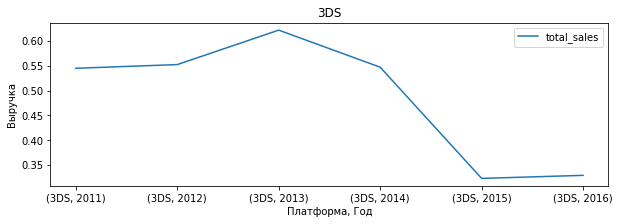

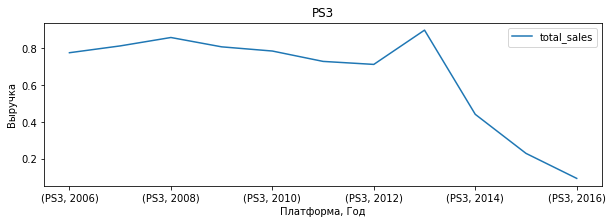

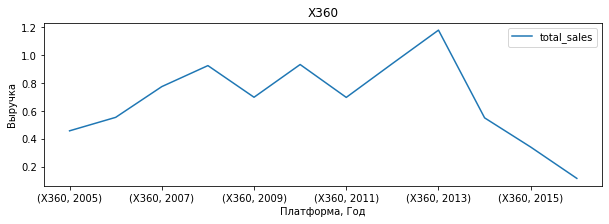

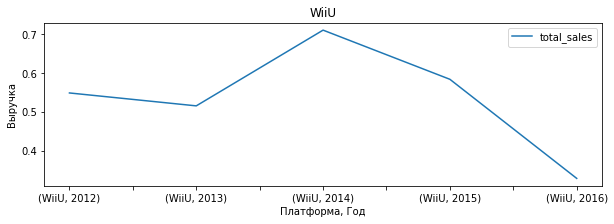

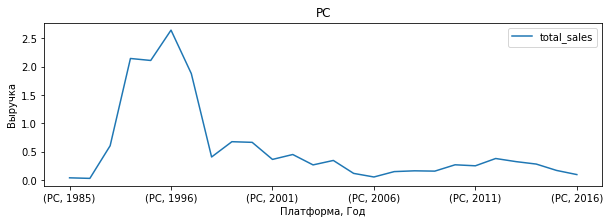

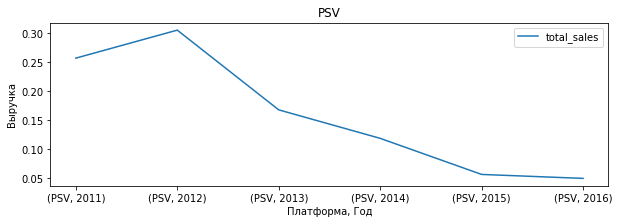

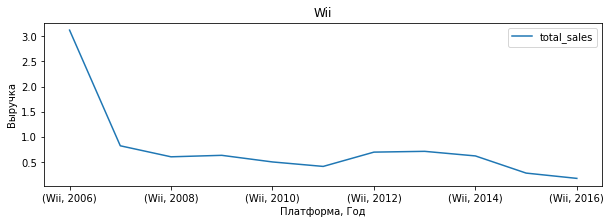

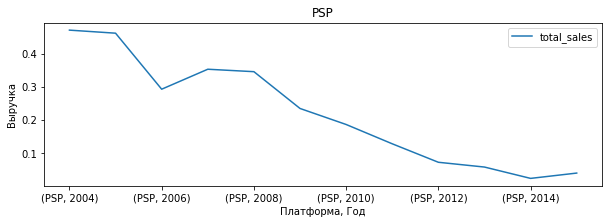

In [61]:
# выгрузим отсортированный список актуальных платформ по выручке
tmpa = actual_data.pivot_table(
    index='platform', values='total_sales', aggfunc= 'sum').sort_values(
    'total_sales', ascending=False) 

# создаем список из наименований актуальных платформ
tmpa_list = tmpa.index[:10].tolist()

# выводим таблицу из которой будем брать инфу по годам
sale_actual_data = data.query(
    "platform.isin(@tmpa_list)")
sale_actual_data = sale_actual_data.pivot_table(
    index=['platform', 'year_of_release'], values = 'total_sales')

# оформляем цикл с выводом графика по каждой актальной платформе
for j in tmpa_list:
    sale_actual_data.query('platform == @j').plot(title=j, figsize=(10, 3)).set(xlabel='Платформа, Год', ylabel='Выручка')

In [62]:
tmpa.head(3)

,total_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68


Топ платформы по выручке за последние 3 года представленного датасета: PS4, XOne, 3DS.

Для наглядности, сравним выручку платформ друг с другом на одном графике.

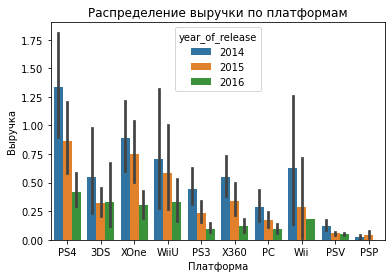

In [63]:
sns.barplot(
    y='total_sales', 
    x='platform', 
    hue='year_of_release', 
    data = actual_data).set(title='Распределение выручки по платформам', xlabel='Платформа', ylabel='Выручка');

Наиболее потенциальные платформы: PS4, 3DS, XOne, WiiU. Они показывают значительно большую выручку за последние 3 года в отличие от своих конкурентов. 

#### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат.

Мы уже выводили продажи за последние 3 года и определили топ потенциальных платформ. Выведем выручку по платформам за последний год, чтобы подтвердить положительную динамику для этих платформ.

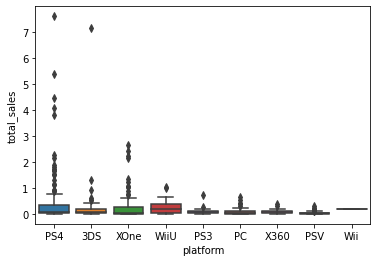

In [64]:
stat_games = actual_data[(actual_data['year_of_release'].isin([2016]))]
sns.boxplot(x='platform', y='total_sales', data=stat_games);

(0.0, 0.42)

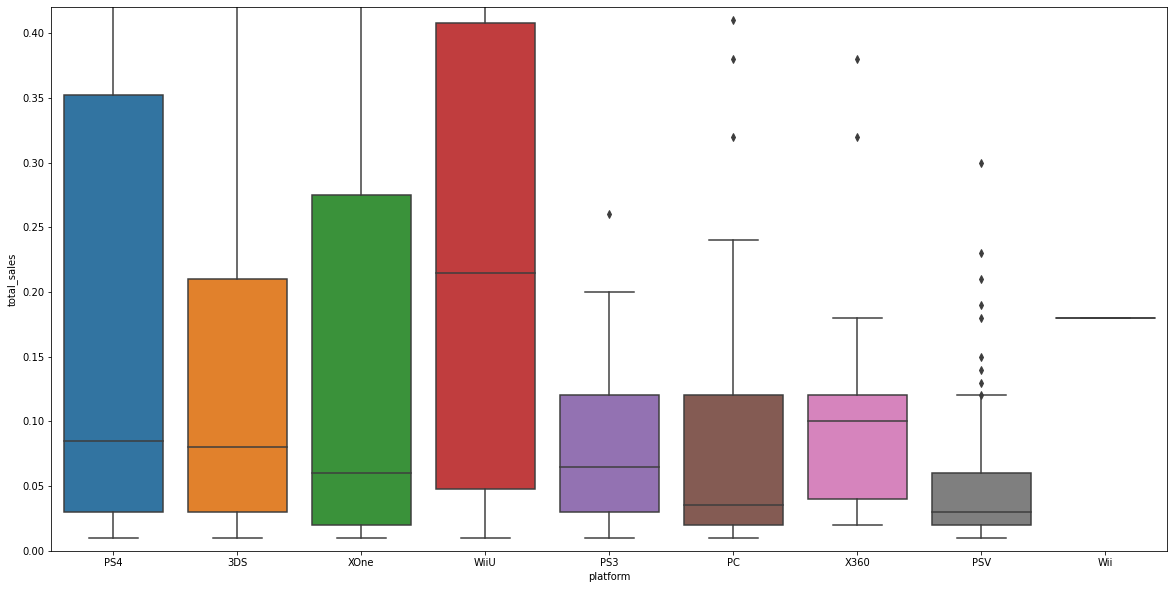

In [71]:
plt.figure(figsize=[20, 10])

stat_games = actual_data[(actual_data['year_of_release'].isin([2016]))]
sns.boxplot(x='platform', y='total_sales', data=stat_games)

plt.ylim(0, .42)

Судя по выбросам на графике видно, что платформы PS4, 3DS, XOne  - обладатели игр с рекордной выручкой за 2016 год, представленный в датасете. Посмотрим как распределяется выручка внутри актуальных платформ по всем играм.

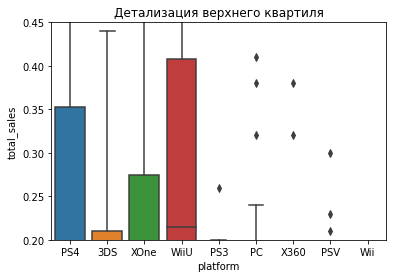

In [1094]:
# Рассмотрим верхний квартиль
stat_games = actual_data[(actual_data['year_of_release'].isin([2016]))]
sns.boxplot(x='platform', y='total_sales', data=stat_games).set(title='Детализация верхнего квартиля');
plt.ylim(0.2, 0.45);

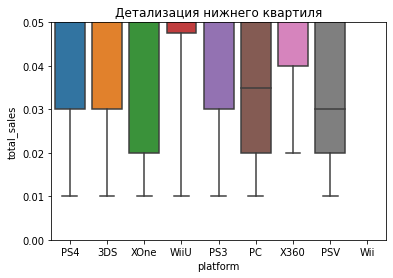

In [1095]:
# Рассмотрим нижний квартиль
stat_games = actual_data[(actual_data['year_of_release'].isin([2016]))]
sns.boxplot(x='platform', y='total_sales', data=stat_games).set(title='Детализация нижнего квартиля');
plt.ylim(0, 0.05);

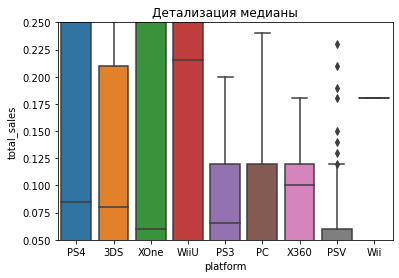

In [1096]:
# Рассмотрим медиану
stat_games = actual_data[(actual_data['year_of_release'].isin([2016]))]
sns.boxplot(x='platform', y='total_sales', data=stat_games).set(title='Детализация медианы');
plt.ylim(0.05, 0.25);

Обратим внимание на квартили (медиану, 25ый и 75ый). Мы видим, что прибыль с игр на платформе WiiU медианно выше, чем у всех отсальных платформ. В среднем на платформе WiiU выручка от каждой игры распределяется в значениях от 0,048 до 0,41 млн, в то время как, например на платформе PS4 это значения 0,035 - 0,35. 

#### Посмотрим, как влияют на продажи внутри платформы PS4 отзывы пользователей и критиков. 
Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

##### Корреляция выручки с отзывами критиков

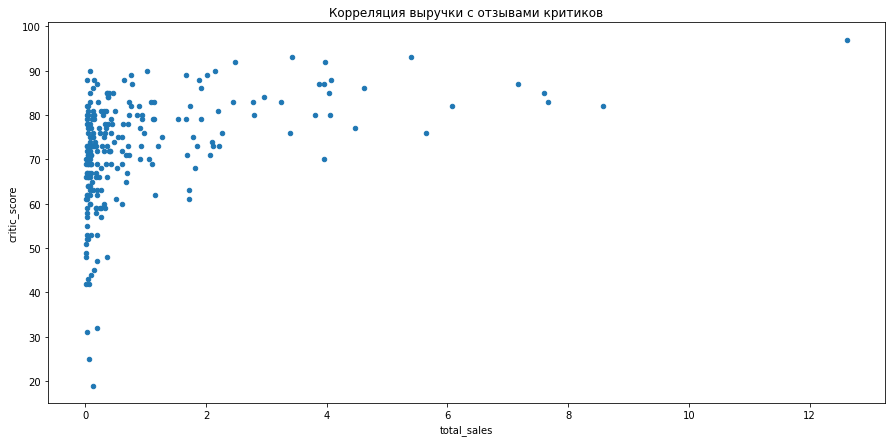

In [1097]:
data_ps4 = actual_data.query('platform=="PS4"')
data_ps4.plot(x='total_sales', 
              y='critic_score', 
              kind='scatter', 
              figsize=(15,7)).set(title='Корреляция выручки с отзывами критиков');

In [1098]:
data_ps4['total_sales'].corr(data_ps4['critic_score']) # выведем корреляцию для критиков

0.40266141068104083

##### Корреляция выручки с отзывами пользователей

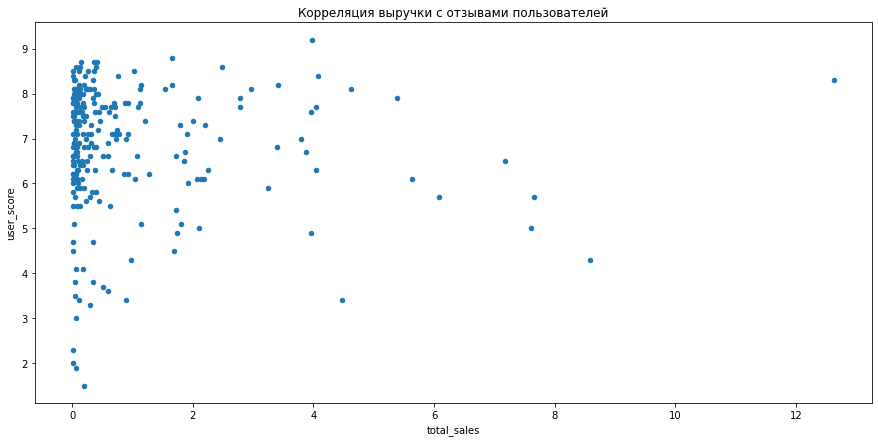

In [1099]:
data_ps4 = actual_data.query('platform=="PS4"')
data_ps4.plot(x='total_sales', 
              y='user_score', 
              kind='scatter', 
              figsize=(15,7)).set(title='Корреляция выручки с отзывами пользователей');

In [1100]:
data_ps4['total_sales'].corr(data_ps4['user_score']) # выведем корреляцию для пользователей

-0.040131589472697356

##### Вывод

Для платформы PS4 корреляция продаж и отзывов пользователей отсутствует (-0.04).

Оценки критиков коррелируют значительно сильнее (0,4) - средняя положительная зависимость.

Получается, критики точнее прогнозируют успех игры.

Cвязь между продажами и оценками экспертов для всех платформ является прямой, слабой степени выраженности (во всех случаях коэффициент около 0,3-0,42). Для пользователей связь отследить сложнее, тк в зависимости от платформы коэфициент находится в диапазоне -0,07-0,4. Для платформы WiiU коэффициент корреляции выручки с отзывами пользователя составляет 0,4 - средняя положительная зависимость.

Соотнесем выводы с продажами игр на других платформах (например WiiU, 3DS, XOne).

In [1101]:
data_wiiu = actual_data.query('platform=="WiiU"')

print("Корреляция для критиков", data_wiiu['total_sales'].corr(data_wiiu['critic_score']))
print("Корреляция для пользователей", data_wiiu['total_sales'].corr(data_wiiu['user_score']))

Корреляция для критиков 0.370201412480884
Корреляция для пользователей 0.4079264579217078


In [1102]:
data_3ds = actual_data.query('platform=="3DS"')

print("Корреляция для критиков", data_3ds['total_sales'].corr(data_3ds['critic_score']))
print("Корреляция для пользователей", data_3ds['total_sales'].corr(data_3ds['user_score']))

Корреляция для критиков 0.31411749286905105
Корреляция для пользователей 0.2151932718527028


In [1103]:
data_xone = actual_data.query('platform=="XOne"')

print("Корреляция для критиков", data_xone['total_sales'].corr(data_xone['critic_score']))
print("Корреляция для пользователей", data_xone['total_sales'].corr(data_xone['user_score']))

Корреляция для критиков 0.42867694370333226
Корреляция для пользователей -0.0703839280647581


#### Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

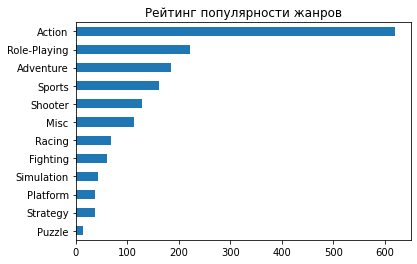

In [1104]:
actual_data['genre'].value_counts().sort_values(
    ascending=True).plot.barh(title='Рейтинг популярности жанров'); 

Самые популярные жанры: Action, Role-Playing, Adventure. Жанр Action более чем в 2 раза опережает конкурентов по своей распространенности.
Проверим как это отражается на выручке.

In [1105]:
sale_genre = actual_data.pivot_table(
    index='genre', values='total_sales', aggfunc='median').sort_values(by='total_sales', ascending=False)
sale_genre.head()

,total_sales
genre,
Shooter,0.515
Sports,0.180
Platform,0.140
Fighting,0.125
Role-Playing,0.110


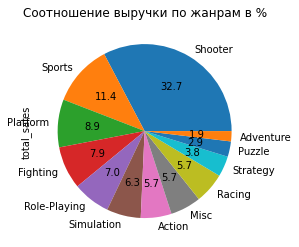

In [1106]:
sale_genre['total_sales'].plot.pie(
    rot=45, autopct='%.1f', title='Соотношение выручки по жанрам в %');

#### Вывод

У большинства платформ с топовой выручкой отслеживается устойчивое падение прибыли c каждым годом. Со временем платформы стремительно меняются: средний жизненный цикл игровых платформ 7 лет, а в среднем каждые 1.6 года появляется новая платформа. 

Наиболее потенциальные платформы: PS4, 3DS, XOne, WiiU. Прибыль с игр на платформе WiiU медианно выше, чем у всех отсальных платформ. В среднем на платформе WiiU выручка от каждой игры распределяется в значениях от 0,048 до 0,41 млн, в то время как, например на платформе PS4 это значения 0,035 - 0,35 млн.

Cвязь между продажами и оценками экспертов для всех платформ является прямой, слабой степени выраженности (во всех случаях коэффициент около 0,3-0,42). Для пользователей связь отследить сложнее, тк в зависимости от платформы коэфициент находится в диапазоне -0,07-0,4. Для платформы WiiU коэффициент корреляции выручки с отзывами пользователя составляет 0,4 - средняя положительная зависимость. В сухом остатке выходит, что критики точнее прогнозируют успех игры, чем пользователи.

Самые популярные жанры: Action, Role-Playing, Adventure. Жанр Action более чем в 2 раза опережает конкурентов по своей распространенности. Но говоря о выручке - Shooter топовый жанр, стабильно приносит высокий медианный доход с игры 0.515 млн, опережая ближайшего конкурента по жанру Sports почти в 3 раза. Тройку лидеров замыкает жанр Platform с медианной выручкой 0,14


### Составим портрет пользователя каждого региона
* Определим для пользователя каждого региона (NA, EU, JP):
    * Самые популярные платформы (топ-5). Опишим различия в долях продаж.
    * Самые популярные жанры (топ-5).
    * Влияет ли рейтинг ESRB на продажи в отдельном регионе?

#### Самые популярные платформы (топ-5). Опишем различия в долях продаж.

In [1107]:
# data_2016 = data.query('year_of_release == 2016')

In [1108]:
na_data = actual_data.pivot_table(
    index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
na_data.head(5)

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05


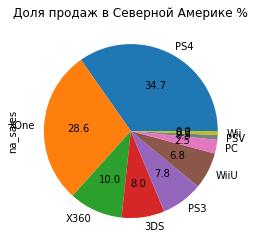

In [1109]:
na_data['na_sales'].plot.pie(rot=45, autopct='%.1f', title='Доля продаж в Северной Америке %');

In [1110]:
eu_data = actual_data.pivot_table(
    index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
eu_data.head()

,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12


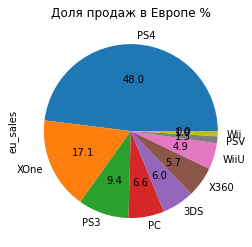

In [1111]:
eu_data['eu_sales'].plot.pie(rot=45, autopct='%.1f', title='Доля продаж в Европе %');

In [1112]:
jp_data = actual_data.pivot_table(
    index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
jp_data.head(5)

,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31


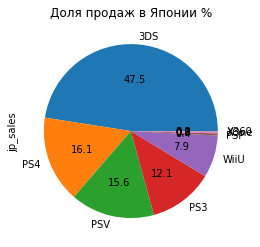

In [1113]:
jp_data['jp_sales'].plot.pie(rot=45, autopct='%.1f', title='Доля продаж в Японии %');

ТОП-5 самых популярных платформ:

Северная Америка: PS4, XOne, X360, 3DS, PS3

Европа: PS4, XOne, PS3, PC, 3DS 

Япония: 3DS, PS4, PSV, PS3, WiiU

Доля продадж игр на платформе PS4 в Северной Америке составляет 34,7%, в то время как в Европе 48%, при том что платформа лидирует по продажам на рынках обоих регионов. В Японии лидирует платформа 3DS с долей на рынке 47,5%. PS4 в Японии на втором месте и его доля 16,1%.

#### Самые популярные жанры (топ-5)

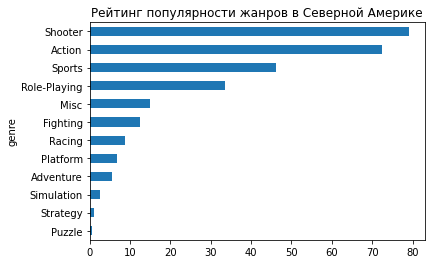

In [1114]:
na_data_genre = actual_data.pivot_table(
    index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
na_data_genre['na_sales'].sort_values(ascending=True).plot.barh(title='Рейтинг популярности жанров в Северной Америке'); 

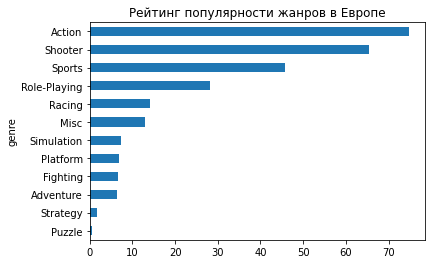

In [1115]:
eu_data_genre = actual_data.pivot_table(
    index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
eu_data_genre['eu_sales'].sort_values(ascending=True).plot.barh(title='Рейтинг популярности жанров в Европе'); 

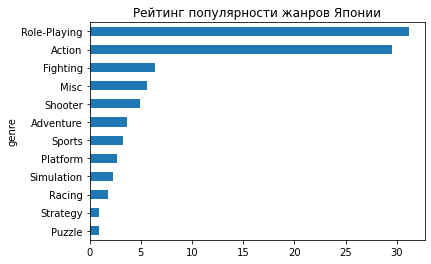

In [1116]:
jp_data_genre = actual_data.pivot_table(
    index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
jp_data_genre['jp_sales'].sort_values(ascending=True).plot.barh(title='Рейтинг популярности жанров Японии'); 

ТОП-5 самых популярных жанров:

Северная Америка: Shooter, Action, Sports, Role-Playing, Misc

Европа: Action, Shooter, Sports, Role-Playing, Racing 

Япония: Role-Playing, Action, Fighting, Adventure, Misc, Shooter

В Европе и америке лидирует популярность шуттеров, тогда как в Японии самый популярный жанр - Action.

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

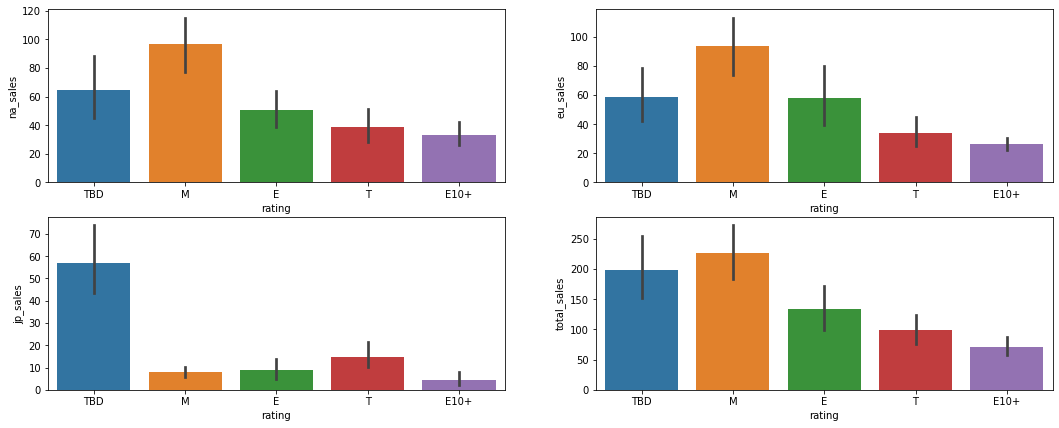

In [1117]:
fig, axis = plt.subplots(2,2, figsize=(18,7))
sns.barplot(y = 'na_sales', x = 'rating', data = actual_data, estimator=sum, ax=axis[0,0]);
sns.barplot(y = 'eu_sales', x = 'rating', data = actual_data, estimator=sum, ax=axis[0,1]);
sns.barplot(y ='jp_sales', x = 'rating', data = actual_data, estimator=sum, ax=axis[1,0]);
sns.barplot(y = 'total_sales', x = 'rating', data = actual_data, estimator=sum, ax=axis[1,1]);

Влияние рейтинга ESRB на продажи в отдельных регионах есть и это проявляется на графике. Исключение составляет Япония, здесь общие продажи у игр без рейтинга (TBD) выше. Возможно, это связано с тем, что у Японцев есть другой рейтинг, выполняющий смежные функции.

#### Вывод

ТОП-5 самых популярных платформ:

Северная Америка: PS4, XOne, X360, 3DS, PS3

Европа: PS4, XOne, PS3, PC, 3DS

Япония: 3DS, PS4, PSV, PS3, WiiU

Доля продадж игр на платформе PS4 в Северной Америке составляет 34,7%, в то время как в Европе 48%, при том что платформа лидирует по продажам на рынках обоих регионов. В Японии лидирует платформа 3DS с долей на рынке 47,5%. PS4 в Японии на втором месте и его доля 16,1%.

ТОП-5 самых популярных жанров:

Северная Америка: Shooter, Action, Sports, Role-Playing, Misc

Европа: Action, Shooter, Sports, Role-Playing, Racing

Япония: Role-Playing, Action, Fighting, Adventure, Misc, Shooter

В Европе и америке лидирует популярность жанров Shooter и Action, тогда как в Японии самый популярный жанр - Role-Playing. Возможно это связано с популярностью определенных платформ на рынках этих стран и особенным менталитетом. 

Влияние рейтинга ESRB на продажи в отдельных регионах есть и это проявляется на графике. Исключение составляет Япония, здесь общие продажи у игр без рейтинга (TBD) выше. Рейтинг ESRB - это американский рейтинг, а в Японии есть своё рейтинговое агентство (CERO).

###  Проверим гипотезы
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action и Sports разные.

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H0 = cредние пользовательские рейтинги платформ Xbox One и PC статистически одинаковые

H1 = cредние пользовательские рейтинги платформ Xbox One и PC статистически различаются

In [1118]:
sample_1 = actual_data.loc[(actual_data['platform'] == 'XOne') & ~(actual_data['user_score'].isna())]['user_score']
sample_2 = actual_data.loc[(actual_data['platform'] == 'PC') & ~(actual_data['user_score'].isna())]['user_score']

# мы используем две выборки с актуальными данными отзывов за последние 8 лет: 
# отзывы (заполненные) по платформе Xbox в sample_1, и sample_2 вторая выборка по платформе PC

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(sample_1, sample_2)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


На основании статистического теста у нас нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются.

#### Средние пользовательские рейтинги жанров Action и Sports разные

H0 = cредние пользовательские рейтинги жанров Action и Sports статистически одинаковые

H1 = cредние пользовательские рейтинги жанров Action и Sports различаются

In [1119]:
sample_1 = actual_data.loc[(actual_data['genre'] == 'Action') & ~(actual_data['user_score'].isna())]['user_score']
sample_2 = actual_data.loc[(actual_data['genre'] == 'Sports') & ~(actual_data['user_score'].isna())]['user_score']

# мы используем две выборки с актуальными данными отзывов за последние 8 лет: 
# отзывы (заполненные) по жанру Action в sample_1, и sample_2 вторая выборка по жанру Sports

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(sample_1, sample_2)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу в пользу альтернативной


В ходе статистического теста мы отвергли нулевую гипотезу о том, что cредние пользовательские рейтинги жанров Action и Sports статистически одинаковые, это значит, что у нас есть основания утверждать, что cредние пользовательские рейтинги жанров Action и Sports значимо различаются.

#### Вывод

Для проверки гипотез мы использовали выборки с актуальными данными отзывов за последние 3 года. 

На основании статистического теста 5.1 у нас нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются. Также на основании проделанного теста 5.2 у нас есть основания утверждать, что cредние пользовательские рейтинги жанров Action и Sports значимо различаются.

Для проверки гипотез я выбрал методику scipy.stats.ttest_ind, так как с его помощью можно сравнить средние двух совокупностей. Метод st.ttest_ind проверяет средние двух совокупностей на равенство. Нулевая гипотеза предполагает равенство средних исследуемых генеральных совокупностей. После, полученное p-value показывает вероятность, с которой мы ошибемся, приняв альтернативную гипотезу. Если она достаточно мала, можем отвергнуть нулевую гипотезу и принять альтернативную (средние не равны), если достаточно велика - не можем отвергнуть нулевую, приходится её принять (средние равны).

### Вывод

#### Сводка

Мы изучили файл и обработали неявные дубликаты, посчитали суммарные продажи во всех регионах и записали их в отдельный столбец total_sales. 

В процессе анализа файла обработали имеющиеся данные и удалили строки, которые нет возможности корректно идентифицировать. Множество строк с пропущенными значениями столбцов critic_score и user_score могли образоваться в связи с отсутствующими методиками сбора данных, к примеру на ранних этапах до 2000 года. Пропущенные данные ESRB могут говорить о том, что продукт не был отправлен на оценку в ESRB для присвоения рейтинга. Рейтинги ESRB дейтвительны в США и Канаде. Но есть и другие рейтинговые системы оценки игр: PEGI в Европе, CERO в Японии.

Изучив, сколько игр выпускалось в разные годы заметно, как начиная с 1995 года начался динамический рост релиза новых игр, который продолжался до 2008 года. После заметно резкое падение в количестве релизов до 2013 года, после чего ситуация на рынке стабилизировалась. Возможно, падение с 2008 по 2013 год связано с мировым финансовым кризисом того же периода. Отчасти, производители могли просто поменять концепцию в сторону "усложнения" игр, что увеличило время от начала создания продукта до выхода в пром.

У большинства платформ с топовой выручкой отслеживается устойчивое падение прибыли c каждым годом. Со временем платформы стремительно меняются: средний жизненный цикл игровых платформ 7 лет, а в среднем каждые 1.6 года появляется новая платформа.

Такая динамика изменений в индустрии сужает актуальный период для построения прогноза на 2017 год. Платформу X360 в 2016 году уже не выпускали, у PS3 поддержка закончилась так же в 2016 году. Nintendo WII и DS тоже не поддерживаются с 2013 года. Для оценки потенциала продукта мы взяли срез данных за последние 3 года так как это поможет наиболее точного построить прогноз на основе данных актуальных платформ.

Наиболее потенциальные платформы: PS4, 3DS, XOne, WiiU. Прибыль с игр на платформе WiiU медианно выше, чем у всех остальных платформ. В среднем на платформе WiiU выручка от каждой игры распределяется в значениях от 0,048 до 0,41 млн, в то время как, например на платформе PS4 это значения 0,035 - 0,35 млн.

Самые популярные жанры: Action, Role-Playing, Adventure. Жанр Action более чем в 2 раза опережает конкурентов по своей распространенности. Но говоря о выручке - Shooter топовый жанр, стабильно приносит высокий медианный доход с игры 0.515 млн, опережая ближайшего конкурента по жанру Sports почти в 3 раза. Тройку лидеров замыкает жанр Platform с медианной выручкой 0,14

Cвязь между продажами и оценками экспертов для всех платформ является прямой, слабой степени выраженности (во всех случаях коэффициент около 0,3-0,42). Для пользователей связь отследить сложнее, тк в зависимости от платформы коэфициент находится в диапазоне -0,07-0,4. Для платформы WiiU коэффициент корреляции выручки с отзывами пользователя составляет 0,4 - средняя положительная зависимость. В сухом остатке выходит, что критики точнее прогнозируют успех игры, чем пользователи.

ТОП-5 самых популярных платформ:

Северная Америка: PS4, XOne, X360, 3DS, PS3

Европа: PS4, XOne, PS3, PC, 3DS

Япония: 3DS, PS4, PSV, PS3, WiiU

Доля продадж игр на платформе PS4 в Северной Америке составляет 34,7%, в то время как в Европе 48%, при том что платформа лидирует по продажам на рынках обоих регионов. В Японии лидирует платформа 3DS с долей на рынке 47,5%. PS4 в Японии на втором месте и его доля 16,1%.

ТОП-5 самых популярных жанров:

Северная Америка: Shooter, Action, Sports, Role-Playing, Misc

Европа: Action, Shooter, Sports, Role-Playing, Racing

Япония: Role-Playing, Action, Fighting, Adventure, Misc, Shooter

В Европе и америке лидирует популярность жанров Shooter и Action, тогда как в Японии самый популярный жанр - Role-Playing. Возможно это связано с популярностью определенных платформ на рынках этих стран и особенным менталитетом.

Мы проверили гипотезы на выборке с актуальными данными отзывов за последние 3 года.

На основании статистического теста 5.1 у нас нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются. Также на основании проделанного теста 5.2 у нас есть основания полагать, что cредние пользовательские рейтинги жанров Action и Sports значимо различаются.

#### Рекомендации

Говоря о рекомендациях, мы должны сделать ставку на топовые платформы, имеющие наибольшую долю на рынке: PS4 (для Европейского и Американского рынка) и 3DS (для рынка Японии). Наиболее выигрышный жанр для глобального рынка - Action. Если сегментировать по регионам, то для американского рынка выгоднее будет выпустить игру жанра Shooter, в то вроемя как для Японского - Role-Playing. Нужно определиться с направлением для более точного прогноза.

Обращаясь к рейтингам ESRB, стоит сделать ставку на продвижение игр с рейтингом М(для взрослых) или Е(для всех) для рынков Европы и Америки. Для Японского рынка стоит отдельно проанализирвоать рейтинги CERO.

Продвигая продукт, не стоит заострять внимание на оценке пользователей, тк прямой связи между выручкой и их оценками нет. Стоит уделять внимание оценке критиков, тк критики статистически точнее прогнозируют успех игры, чем пользователи.